In [1]:
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/Users/tianyuyang/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
with open('instances.jsonl','r') as f:
    instances = []
    for line in f:
        
        instances.append(json.loads(line))
with open('truth.jsonl', 'r') as f:
    labels = []
    for line in f:
        labels.append(json.loads(line))

In [3]:
# summary of the data
# including number of observation
# number of obs in each category
# number of missing value in each variable
df = pd.DataFrame(instances)
df = df.set_index('id')
labels = pd.DataFrame(labels)
labels = labels.set_index('id')
df['label']  = 0
df['label'][labels['truthClass'] == 'clickbait'] = 1
df['truthJudgments'] = labels.truthJudgments

/Users/tianyuyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [4]:
df = df.reset_index().drop(['id','postMedia'],axis = 1)
df.postTimestamp = pd.to_datetime(df.postTimestamp)

In [5]:
print(df['label'].sum())
df.shape

4761


(19538, 9)

In [6]:
# check missing values 
def check_empty(df):
    for c in df.columns:
        print(c)
        count = 0
        for i in df[c]:
            if i ==[]:
                count+= 1
        
        print(count)
check_empty(df)
df.isna().sum()

postText
0
postTimestamp
0
targetCaptions
2320
targetDescription
0
targetKeywords
0
targetParagraphs
0
targetTitle
0
label
0
truthJudgments
0


postText             0
postTimestamp        0
targetCaptions       0
targetDescription    0
targetKeywords       0
targetParagraphs     0
targetTitle          0
label                0
truthJudgments       0
dtype: int64

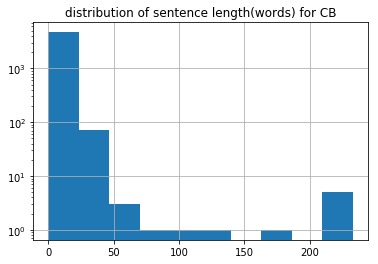

average sentence length(words) for CB:  11.564377231674017
average sentence length(words) for nonCB:  11.158624890031806


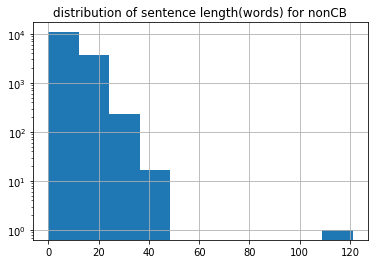

In [7]:
# explore titles of the observations
## length of sentence
## length of words
## content words vs function words
## stops words
## hyperbolic word
## punctuation patterns
## common phrases
## grammatical informations
## check irregular cases

# average length of sentence
## in terms of word
def ana_length_w(df):
    
    cblens = df['targetTitle'][df['label']==1].apply(lambda x: len([i for i in nltk.word_tokenize(x) if i.isalnum()]))
    noncblens = df['targetTitle'][df['label']==0].apply(lambda x:len([ i for i in nltk.word_tokenize(x) if i.isalnum()]))
    
    plt.figure()
    cblens.hist()
    plt.title('distribution of sentence length(words) for CB')
    plt.yscale('log')
    plt.show()
    
    plt.figure()
    noncblens.hist()
    plt.yscale('log')
    plt.title('distribution of sentence length(words) for nonCB')
    
    print('average sentence length(words) for CB: ', cblens.mean())
    
    print('average sentence length(words) for nonCB: ', noncblens.mean())
    
ana_length_w(df)

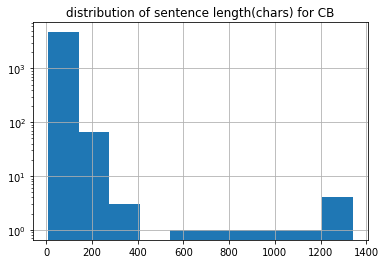

average sentence length(chars) for CB:  69.42659105229994
average sentence length(chars) for nonCB:  70.98193137984705


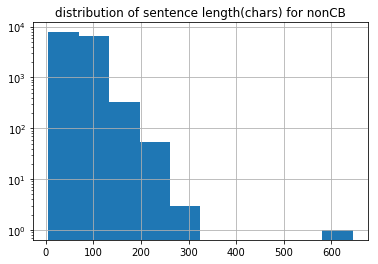

In [8]:
## in terms of character
def average_length_c(df):
    cblens = df['targetTitle'][df['label']==1].apply(len)
    noncblens =  df['targetTitle'][df['label']==0].apply(len)
    
    plt.figure()
    cblens.hist()
    plt.title('distribution of sentence length(chars) for CB')
    plt.yscale('log')
    plt.show()
    
    plt.figure()
    noncblens.hist()
    plt.yscale('log')
    plt.title('distribution of sentence length(chars) for nonCB')
    
    print('average sentence length(chars) for CB: ',cblens.mean())
    print('average sentence length(chars) for nonCB: ', noncblens.mean())
average_length_c(df)

Average # of stop words in CB 2.2299936988027724
Average # of stop words in non CB 2.191513839074237


/Users/tianyuyang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


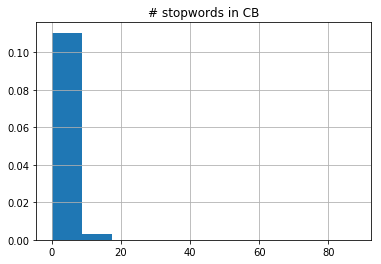

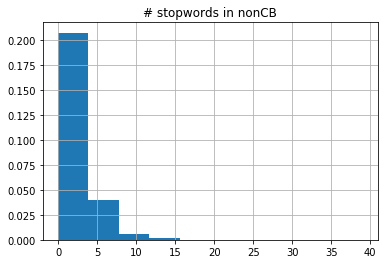

In [9]:
## distributions of stop words
def ana_stopwords(df):
    sws = set(nltk.corpus.stopwords.words('english'))
    def count_sw(string):
        c = 0
        for i in nltk.word_tokenize(string):
            if i in sws:
                c+=1
        return c
    swcb = df['targetTitle'][df['label'] ==1].apply(count_sw)
    swnoncb = df['targetTitle'][df['label']==0].apply(count_sw)
    
    plt.figure()
    swcb.hist(normed = True)
    plt.title('# stopwords in CB')
    
    plt.figure()
    swnoncb.hist(normed = True)
    plt.title('# stopwords in nonCB')
    
    print('Average # of stop words in CB', swcb.mean())
    print('Average # of stop words in non CB', swnoncb.mean())
   

ana_stopwords(df)

Average # of numbers in CB 0.2566687670657425
Average # of numbers in non CB 0.149759761791974


/Users/tianyuyang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


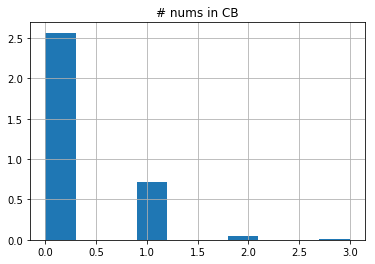

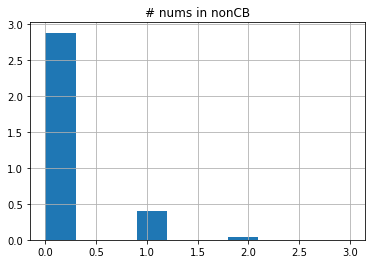

In [10]:
# distribution of non alphabetical characters
## numbers
## using length 4 to represent years
def ana_nums(df):
    def count_nums(string):
        c = 0
        years= {'2010', '2011','2012','2013','2014','2015','2016','2017','2018'}
        numbers = {'one', 'two', 'three', 'four', 'five', 'six', 'nine','ten'}
        for i in nltk.word_tokenize(string):
            if (i.isdigit() or i in numbers) and i not in years:
                c+=1
        return c  
    cb = df['targetTitle'][df['label'] ==1].apply(count_nums)
    noncb = df['targetTitle'][df['label']==0].apply(count_nums)
    
    plt.figure()
    cb[cb<=3].hist(normed = True)
    plt.title('# nums in CB')
    
    
    plt.figure()
    noncb[noncb<=3].hist(normed = True)
    plt.title('# nums in nonCB')
    
    print('Average # of numbers in CB', cb.mean())
    print('Average # of numbers in non CB', noncb.mean())

ana_nums(df)

In [11]:
# starting with number
def ana_start(df):
    sws = set(nltk.corpus.stopwords.words('english'))
    numbers = {'one', 'two', 'three', 'four', 'five', 'six', 'nine','ten'}
    def swithnum(string):
        # the first nonstopword
        tokens = nltk.word_tokenize(string)
        
        for i in tokens:
            if i.lower() not in sws:
                fw = i
                break
        if fw.isnumeric() or fw.lower() in numbers:
            return 1
        else:        return 0
    cb = df['targetTitle'][df['label'] ==1].apply(swithnum)
    noncb = df['targetTitle'][df['label']==0].apply(swithnum)
    print('proportion of titles that start with number')
    print('For CB: ', cb.mean())
    print('Non CB: ', noncb.mean())
ana_start(df)

proportion of titles that start with number
For CB:  0.1419869775257299
Non CB:  0.02936996684036002


In [12]:
# check functionality
sws = set(nltk.corpus.stopwords.words('english'))
numbers = {'one', 'two', 'three', 'four', 'five', 'six', 'nine','ten'}
def swithnum(string):
        # the first nonstopword
    tokens = nltk.word_tokenize(string)
        
    for i in tokens:
        if i.lower() not in sws:
            fw = i
            break
    if fw.isnumeric() or fw.lower() in numbers:
        return 1
    else:       return 0
for i,c in enumerate(df.targetTitle[26:40]):
    print(c)
    print('label',df.label[i+26])
    print('votes', df.truthJudgments[i+26])
    print('output', swithnum(c))
    print('-------------------------------------------\n')

Children with elevated lead levels aren't being tested or diagnosed, study says
label 0
votes [0.0, 1.0, 0.0, 0.6666666666, 0.3333333333]
output 0
-------------------------------------------

Temptations Bass Player Kerry Turman Dies After Performance
label 0
votes [0.6666666666, 0.0, 0.0, 0.0, 0.0]
output 0
-------------------------------------------

United Airlines Faces Questions Over Death of Giant Rabbit 
label 0
votes [0.0, 1.0, 0.0, 0.0, 0.3333333333]
output 0
-------------------------------------------

Who are the winners and losers in Trump's tax plan?
label 0
votes [0.3333333333, 0.3333333333, 0.6666666666, 0.3333333333, 0.6666666666]
output 0
-------------------------------------------

Egypt's Coptic Christians under siege ahead of Pope Francis's visit
label 0
votes [0.0, 0.0, 0.0, 0.6666666666, 0.0]
output 0
-------------------------------------------

Congresswomen meet to discuss missing women of color 
label 0
votes [1.0, 0.0, 0.0, 0.0, 0.0]
output 0
-----------------

Average # of puncts in CB 0.11977306156755621
Average # of puncts in non CB 0.052514042092440955


/Users/tianyuyang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


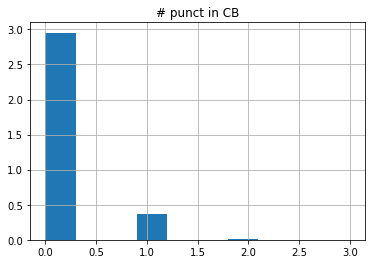

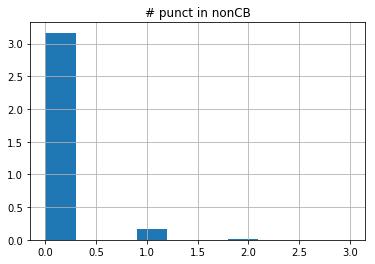

In [13]:
## punctuations
def ana_punct(df):
    
    def count_puncts(string):
        return len(re.findall(r'[?!]',string))
    
    cb = df['targetTitle'][df['label'] ==1].apply(count_puncts)
    noncb = df['targetTitle'][df['label']==0].apply(count_puncts)
    
    plt.figure()
    cb[cb<=3].hist(normed = True)
    plt.title('# punct in CB')
    
    
    plt.figure()
    noncb.hist(normed = True)
    plt.title('# punct in nonCB')
    
    print('Average # of puncts in CB', cb[cb<=3].mean())
    print('Average # of puncts in non CB', noncb.mean())
    

ana_punct(df)

Average sentiment in CB 0.01428170552404944
Average sentiment in non CB -0.05765605332611504


/Users/tianyuyang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


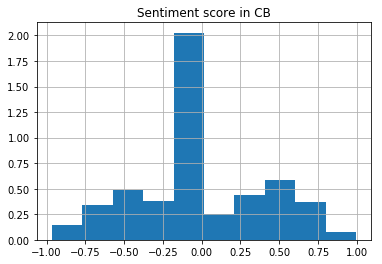

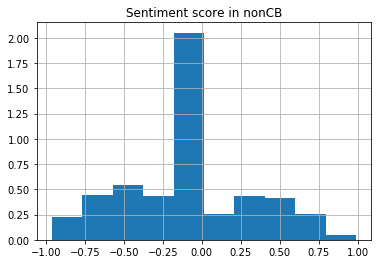

In [14]:
# sentiment distribution
# VADAR sentiment scorer for social media text
def sent_analysis(df):
    sid = SentimentIntensityAnalyzer()
    def sent_score(string):
        return sid.polarity_scores(string)['compound']
    
    cb = df['targetTitle'][df['label'] ==1].apply(sent_score)
    noncb = df['targetTitle'][df['label']==0].apply(sent_score)
    
    plt.figure()
    cb.hist(normed = True)
    plt.title('Sentiment score in CB')

    
    plt.figure()
    noncb.hist(normed = True)
    plt.title('Sentiment score in nonCB')

    print('Average sentiment in CB', cb.mean())
    print('Average sentiment in non CB', noncb.mean())
sent_analysis(df)

In [15]:
# check actual scoring for sentiment
sid = SentimentIntensityAnalyzer()
for i,c in enumerate(df.targetTitle[20:60]):
    print(c)
    print(df.label[i])
    print(sid.polarity_scores(c)['compound'])
    print('-------------------------------------------\n')

Economists Fear Trump’s Tax Plan Only Heightens a ‘Mountain of Debt’ 
0
-0.4939
-------------------------------------------

A quarterback prospect who started 13 games in college has suddenly become the key to the NFL Draft
1
0.296
-------------------------------------------

Anita Sarkeesian ends web series that rocked the world of gaming
0
0.0
-------------------------------------------

This Beyoncé Menu Meme Is The Funniest Thing You'll See All Day
1
0.5574
-------------------------------------------

Trump aides set to air differences over Paris climate deal
0
0.0
-------------------------------------------

14 Strangely Satisfying Videos Of Melting Cheese
0
0.2023
-------------------------------------------

Children with elevated lead levels aren't being tested or diagnosed, study says
0
0.0
-------------------------------------------

Temptations Bass Player Kerry Turman Dies After Performance
0
0.0
-------------------------------------------

United Airlines Faces Questions O

Average subjectivity in CB 0.31925392130223923
Average subjectivity in non CB 0.25926052959876716


/Users/tianyuyang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


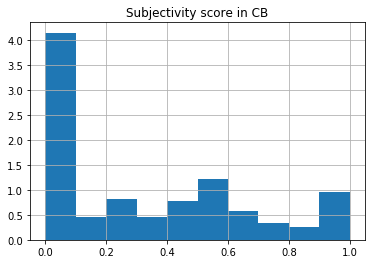

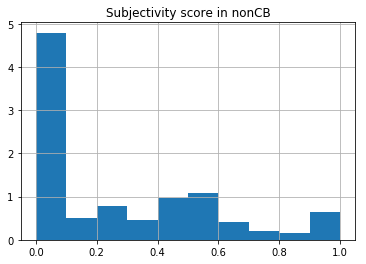

In [16]:
# subjectivity scoring using textblob

def sub_analysis(df):
    def sub_score(string):
        return TextBlob(string).sentiment[1]
    
    cb = df['targetTitle'][df['label'] ==1].apply(sub_score)
    noncb = df['targetTitle'][df['label']==0].apply(sub_score)
    
    plt.figure()
    cb.hist(normed = True)
    plt.title('Subjectivity score in CB')

    
    plt.figure()
    noncb.hist(normed = True)
    plt.title('Subjectivity score in nonCB')

    print('Average subjectivity in CB', cb.mean())
    print('Average subjectivity in non CB', noncb.mean())
sub_analysis(df)

In [17]:
# check actual scoring for subjectivity
for i,c in enumerate(df.targetTitle[:26]):
    print(c)
    print('label: ',df.label[i])
    print('vote: ', df.truthJudgments[i])
    print(TextBlob(c).sentiment[1])
    print('-------------------------------------------\n')

‘Inexcusable’ failures in UK’s response to modern slavery leaving victims destitute while abusers go free, report warns
label:  0
vote:  [0.3333333333, 0.0, 0.3333333333, 0.0, 0.0]
0.55
-------------------------------------------

Donald Trump Appoints Pro-Life Advocate as Assistant Secretary of HHS for Public Affairs
label:  1
vote:  [1.0, 1.0, 1.0, 1.0, 1.0]
0.06666666666666667
-------------------------------------------

The ‘forgotten’ Trump roast: Relive his brutal 2004 thrashing at the New York Friars Club
label:  0
vote:  [0.3333333333, 1.0, 0.3333333333, 0.0, 0.6666666666]
0.7272727272727273
-------------------------------------------

Meet The Happiest Dog In The World, Maru The Husky Who Also Looks Like A Panda!
label:  1
vote:  [1.0, 0.6666666666, 1.0, 1.0, 1.0]
0.0
-------------------------------------------

Tokyo's subway is shut down amid fears over an imminent North Korean missile attack on Japan
label:  0
vote:  [0.0, 0.0, 0.0, 0.0, 0.0]
0.2888888888888889
------------

In [18]:
# sentiment 
# superlative adjective
def sup_ana(df):
    def count_sup(string):
        for i in nltk.pos_tag(nltk.word_tokenize(string.lower())):
            if i[1] == 'JJS':return 1
        return 0
    cb = df['targetTitle'][df['label'] ==1].apply(count_sup)
    noncb = df['targetTitle'][df['label']==0].apply(count_sup)
    print('proportion of titles contains superlative adjective')
    print('For CB: ', cb.mean())
    print('Non CB: ', noncb.mean())
sup_ana(df)

proportion of titles contains superlative adjective
For CB:  0.07414408737660155
Non CB:  0.044934695811057725
